In [1]:
# Setting up google drive 
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
import sys
sys.path.append('/content/gdrive/MyDrive/Colab Notebooks')

Mounted at /content/gdrive


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import my_utils as mu

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform_augmentation = transforms.Compose(
    [transforms.RandomCrop(32, padding=4),
     transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
    ])

batch_size = 32


trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:13<00:00, 13099634.18it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


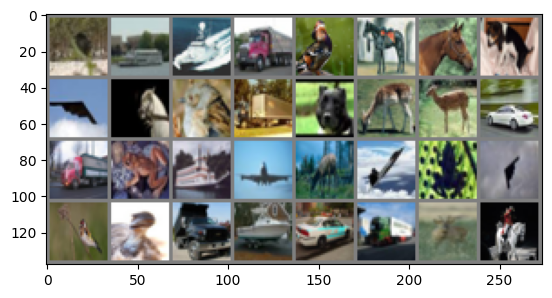

bird  ship  ship  truck bird  horse horse dog   plane horse bird  truck dog   deer  deer  car   truck frog  ship  plane deer  plane frog  plane bird  bird  truck ship  car   truck deer  horse


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [5]:
import torch.nn as nn
import torch.nn.functional as F

In [6]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, k,num_input, num_hidden=64):
        super(Block, self).__init__()

        #Spatial average pool
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(num_input, num_hidden)
        self.fc2 = nn.Linear(num_hidden, k)
        
        

        self.flatten = nn.Flatten()
        self.conv_layers = nn.ModuleList([nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1) for _ in range(k)])
        
        self.relu = nn.ReLU(inplace=True)
        

    def forward(self, x):
        
        a = self.avgpool(x)
        a = self.flatten(a)
        
        a = self.relu(self.fc1(a))
        a = self.relu(self.fc2(a))     
        
        
        conv_outs = [(conv_layer(x)) for conv_layer in self.conv_layers]

        #calculating output
        o = sum([ai[:, :, None, None] * (convi) for ai, convi in zip(a.split(1, dim=1), conv_outs)])

        return o

In [7]:
# model = Block(3,64,5)
# print(model)

In [8]:
class Net(nn.Module):
    def __init__(self,n_blocks=5, k=5, num_classes=10):
        super(Net, self).__init__()

        
        #self.blocks = nn.ModuleList([Block(3, 64, num_input=3,k=k) if i == 0 else Block(self.input_channel*(2**(i-1)), self.input_channel*(2**(i)), num_input=self.input_channel*(2**(i-1)),k=k) for i in range(n_blocks)])
        
        #Creating backbone
        self.backbone = nn.Sequential(
            
            Block(3, 64, num_input=3,k=k),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            Block(64, 128, num_input=64, k=k),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            Block(128, 128, num_input=128, k=k),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),
            #nn.Dropout(0.2),
            nn.Dropout(0.4),
            Block(128, 256, num_input=128,k=k),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            Block(256, 512, num_input=256, k=k),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            #nn.Dropout(0.3)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = nn.Flatten()
        
        #Classifier
        self.Linear1 = nn.Linear(512, 64)
        self.relu = nn.ReLU(inplace=True)
        self.Linear2 = nn.Linear(64, 10)
        #self.Linear1 = nn.Linear(64*(2**(n_blocks-1)), 32)

        
    def forward(self, x):


      #Backbone
      x = self.backbone(x)
      # for block in self.blocks:
      #   x = self.relu(block(x))
      
        
      x = self.avgpool(x)
      x = self.flatten(x)
      #print("x:---",x.shape)

      #Classifier
      x = self.Linear1(x)
      x = self.relu(x)
      x = self.Linear2(x)
     
      return x


In [9]:
net = Net()
print(net)

Net(
  (backbone): Sequential(
    (0): Block(
      (avgpool): AdaptiveAvgPool2d(output_size=(1, 1))
      (fc1): Linear(in_features=3, out_features=64, bias=True)
      (fc2): Linear(in_features=64, out_features=5, bias=True)
      (flatten): Flatten(start_dim=1, end_dim=-1)
      (conv_layers): ModuleList(
        (0-4): 5 x Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (relu): ReLU(inplace=True)
    )
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Block(
      (avgpool): AdaptiveAvgPool2d(output_size=(1, 1))
      (fc1): Linear(in_features=64, out_features=64, bias=True)
      (fc2): Linear(in_features=64, out_features=5, bias=True)
      (flatten): Flatten(start_dim=1, end_dim=-1)
      (conv_layers): ModuleList(
        (0-4): 5 x Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (relu): ReLU(inplace=True)
    )
    (4): BatchNorm2d(128, eps=1e-05, mo

In [10]:
import torch.optim as optim
lr = [0.001,0.0001,0.1]
num_epochs = [10,20,25]
loss = nn.CrossEntropyLoss()
learning_rate,num_epochs = lr[0],num_epochs[1]
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)

In [11]:
def trainf(net, train_iter, test_iter, loss, num_epochs, optimizer, device):
    """Train and evaluate a model with CPU or GPU."""
    net.to(device)
    animator = mu.d2l.Animator(xlabel='epoch', xlim=[0, num_epochs],legend=['train loss', 'train acc', 'test acc'])
    timer = mu.d2l.Timer()
    for epoch in range(num_epochs):
        metric = mu.d2l.Accumulator(3)  # train_loss, train_acc, num_examples
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            net.train()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l*X.shape[0], mu.d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_loss, train_acc = metric[0]/metric[2], metric[1]/metric[2]
            if (i+1) % 50 == 0:
                animator.add(epoch + i/len(train_iter),
                              (train_loss, train_acc, None))
        test_acc = mu.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch+1, (None, None, test_acc))
    print(f'loss {train_loss:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

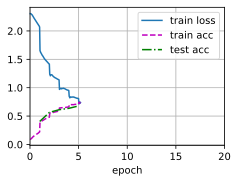

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #choose device: cpu or gpu
print('Using device:', device)
if torch.cuda.is_available(): print(torch.cuda.get_device_name(0)) # print the type of the chosen gpu
trainf(net, trainloader, testloader, loss, num_epochs, optimizer, device)